<a href="https://colab.research.google.com/github/chillivibe/SogangML/blob/master/ex2_lesson1_pets_reprt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import *

Using import *, you don't have to pull library all the time.

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [30]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [31]:
URLs.PETS #어디로부터 가지고 왔는지 알아보기

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [32]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [33]:
path.ls() #ls shows what's inside path=>Here images & annotaions

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations' # '/' creates subpath
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [35]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_74.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_141.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_33.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_148.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [37]:
#ImageDtatBUnch = all the data you need to build a model.
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)
#from_name_re : extracts the label
#re : regular expression(used for extracting text)
#size : for DL, yet GPU has to apply exact same instruction at the same time. So we make images same size
#ds_tfms=get_transforms() : make something size 224


#data normalization = this process is necessary to train your model
data.normalize(imagenet_stats)


ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bengal,wheaten_terrier,Birman,Bengal,boxer
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
beagle,english_cocker_spaniel,pug,Abyssinian,shiba_inu
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

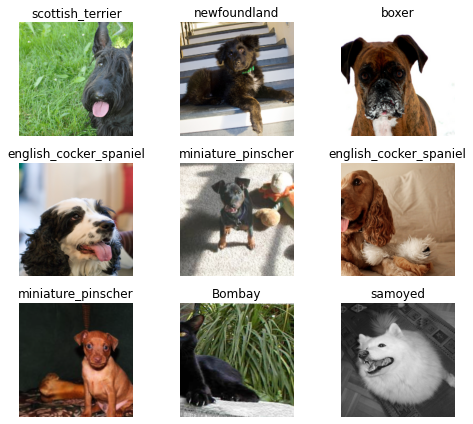

In [38]:
#below function show some of the contents of the data bunch randomly
data.show_batch(rows=3, figsize=(7,6))


In [39]:
print(data.classes)
len(data.classes),data.c

#classes = all the possible label names
#.c : data.c is a property that shows the number of classes

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
#Convolutional Neural Networking Learner
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#tell two things to learner => 1st data / 2nd model(aka.architecture) and size of the model(e.g.34)


### < Transfer Learning >

Take a (pre-trained)model that already knows how to do something well, and make it do your thing.

### < Overfitting >

오버피팅은 high variance 모델로(지엽적인 특성까지 반영), 학습된 것은 잘 예측하는데, 학습되지 않은 것들은 학습된 것의 예측값과는 떨어져서, 낮은 값으로 예측된다.

*언더피팅은 high bias 모델로(일부 특성만 반영하는 편견), 예측값들이 실제 값과 멀어져서 예측한다.

참고 : https://nittaku.tistory.com/289?category=745644

### < How to overcome Overfitting>
:오비피팅은 high variance(feature가 많이 반영된)모델이므로,
trade off로서 bias를 높이고, variance를 낮추는 전략을 쓴다.

sol 1.Validation Set으로 k-fold cross validation하면서 train 방법을 learning rate을 높혀 Regularization
(validation set을 갖추고, k-fold cross validation을 사용하여 training set과 비교한다.train set보다 값이 낮으면 overfitting이다.))

*What is Validation Set?
-set of images that your model does not get to look at.
-Data Bunch만들때 자동생성됨.
-Metrics (e.g. error_rate) get printed out automatically on the validation set

sol 2. Early Stooping

sol 3. Dropout

# **Q1**. Can you explain How to overcome Overfitting using Validation Set? I Searched it, but couldn't understand 100.

In [41]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [42]:
learn.fit_one_cycle(4)
#total time : 6min 54sec
#error rate : 7.4%

epoch,train_loss,valid_loss,error_rate,time
0,1.388658,0.349121,0.110284,01:27
1,0.623513,0.282630,0.090663,01:27
2,0.391354,0.243377,0.083221,01:28
3,0.290556,0.227930,0.078484,01:29


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [44]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
#top loses shows the loss(what are we getting wrong) info that model was most confident of.

len(data.valid_ds)==len(losses)==len(idxs)

True

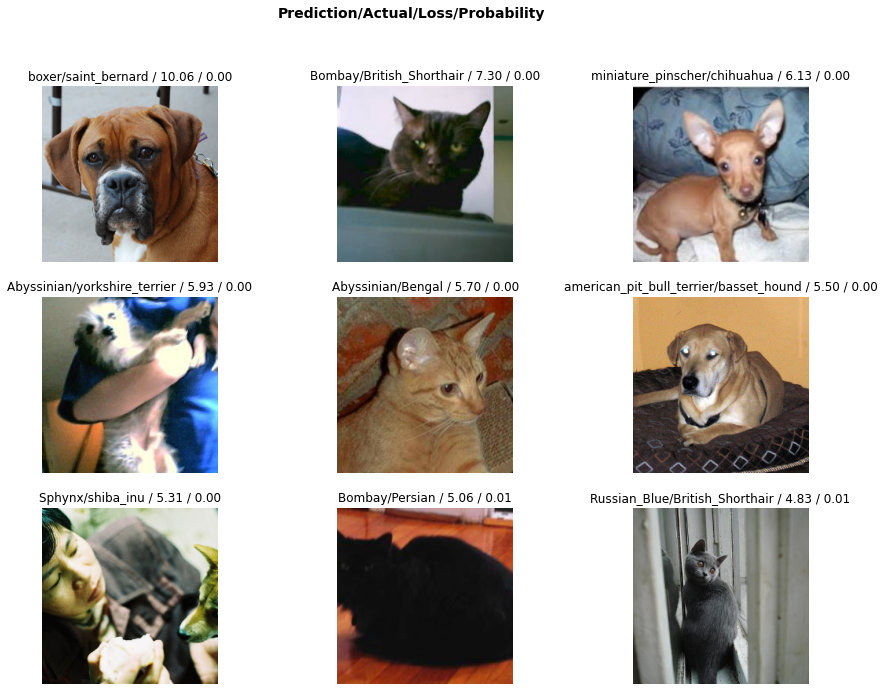

In [45]:
interp.plot_top_losses(9, figsize=(15,11))

In [46]:
#doc() -> similar function as to help()

doc(interp.plot_top_losses)

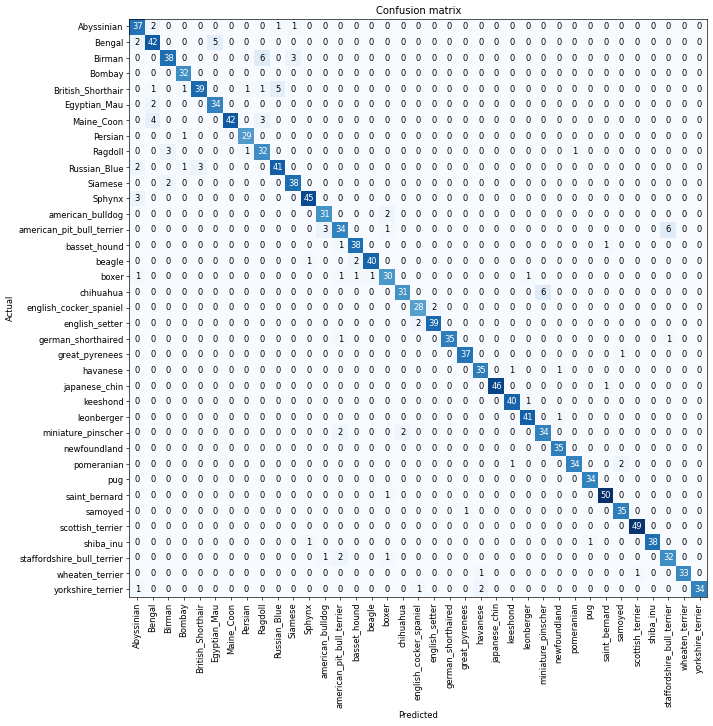

In [47]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [48]:
interp.most_confused(min_val=2)

#don't use confusion_matrix() if you have many classes. Use most_confused().

[('Birman', 'Ragdoll', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Maine_Coon', 'Bengal', 4),
 ('Birman', 'Siamese', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Sphynx', 'Abyssinian', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('pomeranian', 'samoyed', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2),
 ('yorkshire_terrier', 'havanese'

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

How to make our model better = Fine-Tuning.



**unfreeze** is the thing that says please train the whole model. Then I can call **fit_one_cycle again.**

In [0]:
learn.unfreeze()

In [50]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.712225,0.382459,0.131258,01:30


In [0]:
learn.load('stage-1');

In [52]:
#learning rate finder
#: this figures out what is the fastest I can train this neural network at without making it zip off the rails and get blown apart.
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


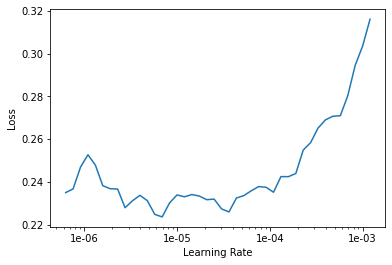

In [53]:
learn.recorder.plot()
#height is loss, width is learning rate.

In [54]:
learn.unfreeze() #=>means train the whole thing
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
#1e-6,1e-4 range is the learning rate before it gets worse.
#make 2nd parameter(1e-4) 10 times smaller than the 1st one(1e-6)

#result
#total_time : 3min 4sec
#error_rate : 7.2%

epoch,train_loss,valid_loss,error_rate,time
0,0.240584,0.222407,0.069012,01:30
1,0.214440,0.219223,0.072395,01:34


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

#bs =  batch size(32~48~64)

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


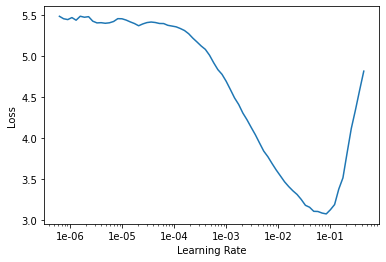

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.731588,0.341514,0.097429,02:16
1,0.445329,0.251626,0.079838,02:15
2,0.280380,0.197783,0.068336,02:15
3,0.188011,0.177826,0.058863,02:14


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [71]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.088838,0.031394,0.991659,00:20
1,0.066805,0.026714,0.993621,00:21
2,0.057663,0.023552,0.995093,00:21


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [63]:
interp = ClassificationInterpretation.from_learner(learn)

In [64]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 8),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Bengal', 'Abyssinian', 3),
 ('British_Shorthair', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('american_bulldog', 'saint_bernard', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('Birman', 'Siamese', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'beagle', 2),
 ('basset_hound', 'beagle', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

## Other data formats

In [65]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [66]:
#scenario 1 : Labels are folder names

# "ImageNet style dataset" : labels name = folder name

(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26) #->create ImageDataBunch

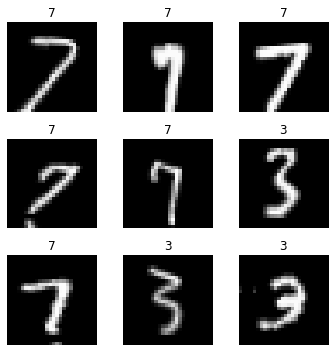

In [68]:
data.show_batch(rows=3, figsize=(5,5))

In [69]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.199676,0.091470,0.963690,00:20
1,0.124246,0.057412,0.980373,00:20


In [70]:
#scenario 1 : CSV file
#yes or not => lables 1 or 0
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

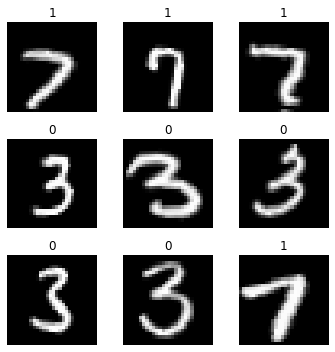

In [73]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [74]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [75]:
#Scenario 3: Using regular expression
#grab the label by using a regular expression.

fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [80]:
doc(ImageDataBunch.from_name_re)
#helps you find labels for data

#Also, if you go to fastai Git there is Working Examples for the document.

In [76]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
#from_name_re
data.classes

['3', '7']

In [77]:
#Scenario 4: Something more complex
#You can create an arbitrary function that extracts a label from the file name or path

data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [78]:
#Scenario 5: You need something even more flexible
#write some code to create an array of labels.

labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [81]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']